In [5]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

"""Note that when loading Xception model we include the densely 
connected classifier on top;in all previous cases we ignored it"""
model = keras.applications.xception.Xception(weights="imagenet")

img_path = keras.utils.get_file(fname="elephant.jpg",
                                origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size) #return a python imaging of soize 299 x 299
    array = keras.utils.img_to_array(img) #return a float32 numpy array of shape (299, 299, 3)
    array = np.expand_dims(array, axis=0) #add a dimension to transform int a batch size of (1, 299, 299, 3)
    array = keras.applications.xception.preprocess_input(array) #pereprocees the batch
    return array

img_array = get_img_array(img_path, target_size=(299, 299))


In [6]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 3us/step
[('n02504458', 'African_elephant', 0.86993945), ('n01871265', 'tusker', 0.076956384), ('n02504013', 'Indian_elephant', 0.023541817)]


In [13]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

In [14]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)


In [15]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [16]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)


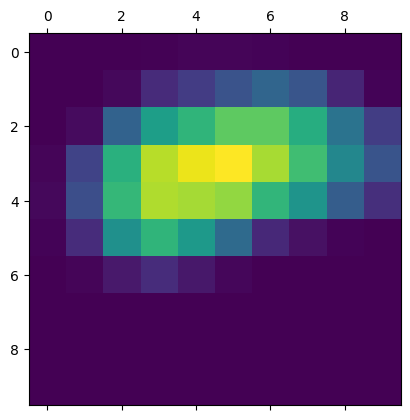

In [17]:
import matplotlib.pyplot as plt

heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [21]:
import matplotlib.cm as cm
import matplotlib

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = matplotlib.colormaps.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)